In [1]:
pip install shap transformers torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import shap
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

df_true = pd.read_csv("fake_cleaned.csv")
df_fake = pd.read_csv("true_cleaned.csv")

# Examine the shape of the dataframes
print("Shape of df_fake:", df_fake.shape)
print("Shape of df_true:", df_true.shape)

# Inspect the columns
print("\nColumns of df_fake:", df_fake.columns.values)
print("Columns of df_true:", df_true.columns.values)

# Check data types
print("\nData types of df_fake:\n", df_fake.dtypes)
print("\nData types of df_true:\n", df_true.dtypes)

# Investigate missing values
print("\nMissing values in df_fake:\n", df_fake.isnull().sum())
print("\nMissing values in df_true:\n", df_true.isnull().sum())

# Calculate descriptive statistics for numerical columns (text length)
print("\nAverage text length in df_fake:", df_fake['text'].str.len().mean())
print("Average text length in df_true:", df_true['text'].str.len().mean())

# Analyze subject distributions
print("\nSubject distribution in df_fake:\n", df_fake['subject'].value_counts())
print("\nSubject distribution in df_true:\n", df_true['subject'].value_counts())

C:\Users\isaac\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Shape of df_fake: (21210, 4)
Shape of df_true: (22848, 4)

Columns of df_fake: ['title' 'text' 'subject' 'date']
Columns of df_true: ['title' 'text' 'subject' 'date']

Data types of df_fake:
 title      object
text       object
subject    object
date       object
dtype: object

Data types of df_true:
 title      object
text       object
subject    object
date       object
dtype: object

Missing values in df_fake:
 title      0
text       0
subject    0
date       0
dtype: int64

Missing values in df_true:
 title      0
text       0
subject    0
date       0
dtype: int64

Average text length in df_fake: 2378.1544082979726
Average text length in df_true: 2617.7732405462184

Subject distribution in df_fake:
 politicsNews    11219
worldnews        9991
Name: subject, dtype: int64

Subject distribution in df_true:
 News               9050
politics           6430
left-news          4309
Government News    1498
US_News             783
Middle-east         778
Name: subject, dtype: int64


In [3]:
# Re-check the date range and missing values
print("\nDate range analysis after cleaning:")
print("Earliest date in df_fake_cleaned:", df_fake['date'].min())
print("Latest date in df_fake_cleaned:", df_fake['date'].max())

print("\nNull values in 'date' column after cleaning:")
print("df_fake_cleaned:", df_fake['date'].isnull().sum())
print("df_true:", df_true['date'].isnull().sum())
# Explore other potential issues
# Check for duplicated rows
print("\nNumber of duplicated rows in df_fake_cleaned:", df_fake.duplicated().sum())
print("Number of duplicated rows in df_true:", df_true.duplicated().sum())

# Further analysis
# Example: Check for empty strings in 'text' columns
print("\nEmpty strings in 'text' column:")
print("df_fake_cleaned:", df_fake['text'].str.strip().eq('').sum())
print("df_true:", df_true['text'].str.strip().eq('').sum())

# Examine the shape of the dataframes
print("\nShape of df_fake:", df_fake.shape)
print("Shape of df_true:", df_true.shape)


Date range analysis after cleaning:
Earliest date in df_fake_cleaned: April 1, 2016 
Latest date in df_fake_cleaned: September 9, 2017 

Null values in 'date' column after cleaning:
df_fake_cleaned: 0
df_true: 0

Number of duplicated rows in df_fake_cleaned: 0
Number of duplicated rows in df_true: 0

Empty strings in 'text' column:
df_fake_cleaned: 0
df_true: 0

Shape of df_fake: (21210, 4)
Shape of df_true: (22848, 4)


In [4]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already present
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))


# Add a label column: 1 for true news, 0 for fake news
df_true["label"] = 1
df_fake["label"] = 0

# Inspect the columns
print("\nColumns of df_fake:", df_fake.columns.values)
print("Columns of df_true:", df_true.columns.values)




Columns of df_fake: ['title' 'text' 'subject' 'date' 'label']
Columns of df_true: ['title' 'text' 'subject' 'date' 'label']


In [5]:
import re
# Combine the datasets
data = pd.concat([df_true, df_fake], ignore_index=True)

def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\[.*?\]', '', text)  # Remove brackets
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply function
#data["text"] = data["title"] + " " + data["text"]  # Combine title and text
data["text"] = data["text"].astype(str).apply(clean_text)

# Shuffle data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
# Use a smaller subset of the data for faster training
subset_size = 10000  # Adjust as needed
data_subset = data.sample(n=subset_size, random_state=42)
X = data_subset['text']
y = data_subset['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import GradScaler, autocast  # For mixed precision training

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Binary classification

# Tokenize the data with a smaller max_length
def tokenize_data(texts, labels, max_length=64):  # Reduced sequence length
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], torch.tensor(labels.tolist()))
# Prepare datasets
train_dataset = tokenize_data(X_train, y_train)
test_dataset = tokenize_data(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\isaac\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
# Mixed precision training setup
scaler = GradScaler()  # For mixed precision training

epochs = 3  # Reduced number of epochs
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Mixed precision training
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    print(f"Epoch {epoch + 1}/{epochs} completed.")

# Evaluation
model.eval()
y_true, y_pred = [], []

C:\Users\isaac\AppData\Local\Temp\ipykernel_10420\2236501902.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
C:\Users\isaac\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
C:\Users\isaac\AppData\Local\Temp\ipykernel_10420\2236501902.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\isaac\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/3 completed.
Epoch 2/3 completed.
Epoch 3/3 completed.


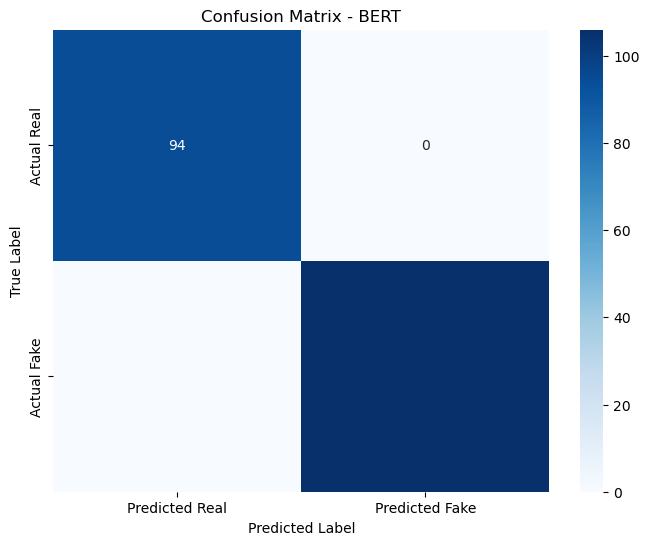

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
AUC-ROC: 1.0000


In [9]:
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - BERT')
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

In [10]:
# from transformers import BertTokenizer, BertForSequenceClassification
# import torch

# # Assuming `model` is your fine-tuned BERT model and `tokenizer` is the tokenizer
# # Save the model's state dictionary
# model_save_path = "./bert_fake_news_model.pth"
# torch.save(model.state_dict(), model_save_path)

# # Save the tokenizer
# tokenizer_save_path = "./bert_fake_news_tokenizer"
# tokenizer.save_pretrained(tokenizer_save_path)

# print(f"Model saved to {model_save_path}")
# print(f"Tokenizer saved to {tokenizer_save_path}")

Model saved to ./bert_fake_news_model.pth
Tokenizer saved to ./bert_fake_news_tokenizer
